In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

# SLAM Part 2

**Overview**

- This notebook contains a generative function for the full SLAM model as illustrated in the figure below.
- The gray part corresponds to the localization chain given a map. In the inference part we use this model to infer the poses together with the map in an incremental fashion....following Bayesian filter approach...

**Visual summary:**

![slam_model](png/slam_full.png)

- **Fig: SLAM Graphical model.**

![inferred_map](png/inferred_map.png)

- **Fig: Inferred map.** Left: Actual poses of an agent in a simulated environment. Right: Inferred occupancy map from "classical" online SLAM approach. 

![map_updates](png/map_updates.png)

- **Fig: Map updates.** Inferred position and how sensor measurements at time $t$ fit the map at $t-1$.

In [15]:
using Gen
using Random
using Distributions
using StatsBase: mean, std, quantile
using BenchmarkTools
using FilePathsBase;
using LinearAlgebra: dot, Diagonal, norm
using JSON
import PyPlot
plt = PyPlot.plt
using JLD

include("src/utils.jl");
include("src/expo_environment.jl");
include("src/part_1.jl");

# Motion model

In [3]:
"Beta-like distribution over a bigger interval with prescribed mean."
@dist function my_scaled_beta(a, mean, scale)
    mean_beta = mean/scale
    b = a/mean_beta - a
    scale*beta(a,b);
end;

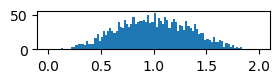

1.0046070323085339

In [4]:
a = 4.
mean_speed = 1.
max_speed = 2.
samples = [my_scaled_beta(a, mean_speed, max_speed) for t=1:2000]
# ------------------
plt.figure(figsize=(3,0.5));
plt.hist(samples, bins=0:max_speed/100:max_speed);
mean(samples)

In [5]:
"""
    Control

Contains the controls of the agent. 
"""
struct Control <: StructIterator
    "speed"
    s::Float64 
    "change of head direction"
    dhd::Float64
end;


"""
    Control(s, dhd) = control_prior(mean_speed, max_speed, sigma_dhd)

Mindlessly samples a random control vector.

Choices:
```
    |
    +-- :s : Float64
    |
    +-- :dhd : Float64
```
"""
@gen function control_model(mean_speed, max_speed, dhd_noise)
    s   ~ my_scaled_beta(4., mean_speed, max_speed)
    dhd ~ normal(0, dhd_noise)
    return Control(s, dhd)
end;

# Rem: The control model could depend on 
# ---  the current observations and the environment 


"""
    motion_model(pose::Pose, u::Control, hd_noise, x_noise) 

A mindless motion model for an agent that does **not** respect environmental boundaries.
That means the map argument is ignored.
"""
@gen function motion_model(pose::Pose, u::Control, hd_noise, x_noise)    
    hd ~ normal(pose.hd + u.dhd, hd_noise) 
    v = [u.s*cos(hd); u.s*sin(hd)]
    x ~ mvnormal(pose.x + v, Diagonal([x_noise, x_noise]))
    return Pose(x, hd)
end;

# Rem: The motion model could depend on the map/environment - one 
# ---  might want to check if the sampled move is in fact a valid one (see the other notebooks).

# SLAM Model

In [16]:
"""
    loc_kernel(t::Int, 
                state::SLAMState, 
                M::Map, 
                control_args,
                motion_args,
                sensor_args)

MC kernel for localization on a given map.
"""
@gen (static) function loc_kernel(t::Int, 
                          pose::Pose, # State of kernel
                          M::Map,
                          control_args,
                          motion_args,
                          sensor_args)
    
    mean_speed, max_speed, dhd_noise = control_args
    hd_noise, x_noise = motion_args
    fov, n, max_val, noise, drop_out = sensor_args
    
    u     = @trace(control_model(mean_speed, max_speed, dhd_noise), :u)
    pose  = @trace(motion_model(pose, u, hd_noise, x_noise), :pose)
    sense = @trace(sensor_model(M, pose, fov, n, max_val, noise, drop_out), :sense)

    return pose
end

loc_chain = Gen.Unfold(loc_kernel);

@gen (static) function slam_model(T::Int, 
                         map_args,
                         control_args,
                         motion_args,
                         sensor_args)
    
    map_size, res, occ_prior = map_args
    fov, n, max_val, noise, drop_out = sensor_args
    
    # Initial state of the MC
    m  = @trace(map_prior(map_size, res, occ_prior), :M)
    p  = @trace(pose_prior(m), :pose)
    sense = @trace(sensor_model(m, p, fov, n, max_val, noise, drop_out), :sense)
    
    # Unfolding the chain
    chain = @trace(loc_chain(T, p, m, control_args, motion_args, sensor_args), :chain)
    
    return chain
end;

Gen.load_generated_functions()

In [21]:
map_args     = (map_size=(2,2), res=1., pr=0.2)
control_args = (mean_speed=1., max_speed=2., dhd_noise=0.1*2π)
motion_args  = (hd_noise=0.3, x_noise=0.3)
sensor_args  = (fov=180, n=50, max_val=10., noise=0.0, drop_out=0.2)


tr = simulate(slam_model, (1, map_args, control_args, motion_args, sensor_args));
get_choices(tr)

│
├── :M
│   │
│   ├── (:m, CartesianIndex(1, 2)) : false
│   │
│   ├── (:m, CartesianIndex(2, 2)) : false
│   │
│   ├── (:m, CartesianIndex(2, 1)) : false
│   │
│   └── (:m, CartesianIndex(1, 1)) : true
│
├── :pose
│   │
│   ├── :hd : 3.686074893605085
│   │
│   └── :x : [1.0, 0.0]
│
├── :sense
│   │
│   └── :z : [10.0, 10.0, 10.0, 10.0, 0.2980496183913206, 0.29067594901989624, 10.0, 10.0, 10.0, 1.7519825513453369, 4.965805873772162, 10.0, 6.256407372917739, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 10.0, 0.5471043423352651, 10.0, 10.0, 10.0, 10.0, 4.988819939508757, 10.0, 8.560215908179083, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 5.893250623897199, 10.0, 4.725519827213402, 10.0, 10.0, 10.0, 10.0, 10.0, 0.948188630931861, 10.0, 10.0, 10.0]
│
└── :chain
    │
    └── 1
        │
        ├── :u
        │   │
        │   ├── :s : 0.9633529868818266
        │   │
        │   └── :dhd : -0.18932481490956182
        │
        ├── :pose
        │   │
        │   ├── :hd : 3.8373

# Load measurement and control data

In [22]:
data = load("example_sensor_data.jld")

┌ Warning: JLD incorrectly extends FileIO functions (see FileIO documentation)
└ @ FileIO /Users/mirko/.julia/packages/FileIO/AmppF/src/loadsave.jl:210


Dict{String,Any} with 10 entries:
  "n"       => 100
  "s"       => [1.0, 1.0, 0.949818, 1.0, 1.0, 1.0, 1.0, 1.0, 0.631622, 1.0, 1.0…
  "fov"     => 180
  "hd"      => [2.68723, 2.68723, 2.68723, 2.68723, 2.02111, 2.96523, 2.96523, …
  "env_id"  => 2010
  "x"       => Any[[15.474, 1.94666], [14.5754, 2.38555], [13.6769, 2.82444], […
  "z"       => Any[[0.949706, 0.925378, 0.905751, 0.89038, 0.878933, 0.871171, …
  "a"       => Any[[-3.11018, -3.04734, -2.98451, -2.92168, -2.85885, -2.79602,…
  "dhd"     => [0.0, 0.0, -8.88178e-16, -0.666124, 0.944122, -4.44089e-16, 4.44…
  "max_val" => Inf

In [ ]:
env = load_env(data["env_id"]; path=p"data/HouseExpo_json");

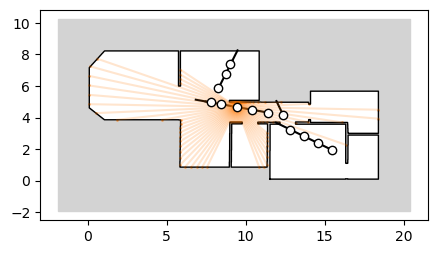

(13,)(12,)(13,)


PyObject <matplotlib.collections.PathCollection object at 0x7fce8680f550>

In [30]:
fov, n, max_val = data["fov"], data["n"], data["max_val"]

poses  = []
senses = []
us     = []
for (x, hd) in zip(data["x"], data["hd"])
    push!(poses, Pose(x, hd))
end


for (s,dhd) in zip(data["s"], data["dhd"])
    push!(us, Control(s,dhd))
end


for (z,a) in zip(data["z"], data["a"])
    push!(senses, Measurement(z, a))
end

T = length(us)

println(size(poses), size(us), size(senses))
t = rand(1:T)
# -------
plt.figure(figsize=(5,5)); plt.gca().set_aspect(1.);
draw_env!(env);
for p in poses
    draw_pose!(p)
end
draw_sense!(senses[t], poses[t])

# Inference

In [31]:
function thresh(M::Map, θ::Float64)
    v = Float64.(val.(M.cells) .> θ)
    return Map(size(M), M.res, v)
end

thresh (generic function with 1 method)

In [32]:
function set_z!(ch, z, t)
    ch[t => :sense => :z] = z    
end

function set_u!(ch, u, t)
    ch[t => :u => :s] = u.s
    ch[t => :u => :dhd] = u.dhd
end

function set_p!(ch, p, t)
    ch[t => :pose => :x]  = p.x
    ch[t => :pose => :hd] = p.hd;
end


set_p! (generic function with 1 method)

## Custom Incremental updates

In [33]:
function my_incremental_sampling(tr, args, diffs, selection, new_obs, num)
    
    tr,w = update(tr, args, diffs, new_obs)
    
    args = get_args(tr)
    diffs = changes(zeros(length(args)))
    
    trs = []
    ws = []
    for i=1:num
        tr′, w′ = regenerate(tr, args, diffs, selection)
        push!(trs, tr′)
        push!(ws, w′)
    end
    return trs, ws
end

my_incremental_sampling (generic function with 1 method)

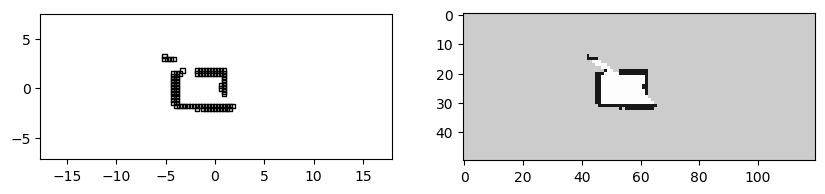

PyObject <matplotlib.image.AxesImage object at 0x7fce8388ca10>

In [34]:
free, prior, occ = ell(0.01), ell(0.2), ell(0.9)
occ_thresh = ell(0.5)

map_args     = (map_size=(120,50), res=.3, ell0=prior)
control_args = (mean_speed=1., max_speed=2., dhd_noise=0.1*2π)
motion_args  = (hd_noise=0.05, x_noise=0.1)
sensor_args  = (fov=180, n=100, max_val=20., noise=.1, drop_out=0.2)

z_eps = map_args.res


m0 = Map(map_args...)
p0 = Pose([0;0], mod(poses[1].hd,2π))
inverse_polar_lidar!(m0, p0, senses[1], z_eps, free, prior, occ)
m = thresh(m0, occ_thresh)

im = expit.(val.(m0.cells))


fig, axs = plt.subplots(1,2, figsize=(10,6));
axs[1].set_aspect(1)
axs[1].set_xlim(bounds(m)[1,:]...)
axs[1].set_ylim(bounds(m)[2,:]...)
draw_sq_map!(m, ax=axs[1],s=10)
draw_map_im!(im, vmin=0, vmax=1, ax=axs[2])

t: 1... occ: 89...  0.069212 seconds (498.18 k allocations: 63.634 MiB, 28.57% gc time)
t: 2... occ: 106...  0.096056 seconds (610.18 k allocations: 69.379 MiB, 18.62% gc time)
t: 3... occ: 122...  0.082430 seconds (513.29 k allocations: 65.403 MiB, 28.50% gc time)
t: 4... occ: 134...  0.070799 seconds (523.50 k allocations: 66.462 MiB, 21.94% gc time)
t: 5... occ: 188...  0.103973 seconds (646.68 k allocations: 72.970 MiB, 16.89% gc time)
t: 6... occ: 202...  0.096735 seconds (657.53 k allocations: 73.983 MiB, 18.20% gc time)
t: 7... occ: 221...  0.102260 seconds (667.45 k allocations: 75.077 MiB, 16.13% gc time)
t: 8... occ: 254...  0.105949 seconds (678.59 k allocations: 76.204 MiB, 16.08% gc time)
t: 9... occ: 310...  0.083122 seconds (584.64 k allocations: 73.143 MiB, 21.44% gc time)
t: 10... occ: 333...  0.091676 seconds (595.87 k allocations: 74.278 MiB, 19.73% gc time)
t: 11... occ: 337... 

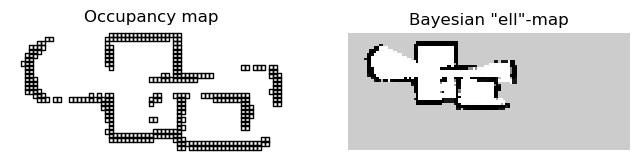

 0.113534 seconds (711.10 k allocations: 79.971 MiB, 14.76% gc time)
t: 12... occ: 340...  0.083642 seconds (613.15 k allocations: 75.845 MiB, 19.79% gc time)


PyObject <matplotlib.image.AxesImage object at 0x7f9cb2916e10>

In [239]:
# Initial trace
ell_map = Map(map_args...)
p0 = Pose([0;0], mod(poses[1].hd,2π))
inverse_polar_lidar!(ell_map, p0, senses[1], z_eps, free, prior, occ)
args = (0, p0, m, control_args, motion_args, sensor_args)
tr, w = generate(loc_chain, args, choicemap())

history = []

for t=1:T
    m = thresh(ell_map, occ_thresh)
    
    new_obs = choicemap()
    set_u!(new_obs, us[t], t)
    set_z!(new_obs, senses[t+1].z, t)
    
    args = (t, p0, m, control_args, motion_args, sensor_args)
    diffs = changes([1,0,1,0,0,0,0])
    selection = select(t => :pose)
    
    print("t: $(t)... occ: $(length(occupied(m)))...")
    @time begin
        trs, ws = my_incremental_sampling(tr, args, diffs, selection, new_obs, 100)
    end

    tr = trs[argmax(ws)]
    p = tr[t => :pose]    
    s = tr[t => :sense]
    inverse_polar_lidar!(ell_map, p, s, z_eps, free, prior, occ)
    
    push!(history, (tr, m))
end




# -----------------
# -----------------
fig, axs = plt.subplots(1,2,figsize=(8,4)); 
axs[1].set_aspect(1.); axs[1].axis("off")
axs[2].set_aspect(1.); axs[2].axis("off")
axs[1].set_title("Occupancy map")
axs[2].set_title("Bayesian \"ell\"-map")
draw_sq_map!(m, ax=axs[1], s=10);
draw_map_im!(expit(ell_map), vmin=0, vmax=1, ax=axs[2])

## Inference w MH updates

t: 1... occ: 89...  0.058046 seconds (499.51 k allocations: 63.759 MiB, 22.62% gc time)
t: 2... occ: 104...  0.061599 seconds (505.99 k allocations: 64.670 MiB, 23.73% gc time)
t: 3... occ: 147...  0.064648 seconds (517.24 k allocations: 66.181 MiB, 20.81% gc time)
t: 4... occ: 150...  0.062543 seconds (524.80 k allocations: 66.884 MiB, 20.16% gc time)
t: 5... occ: 200...  0.068693 seconds (544.49 k allocations: 68.537 MiB, 18.56% gc time)
t: 6... occ: 219...  0.073389 seconds (555.93 k allocations: 69.653 MiB, 20.09% gc time)
t: 7... occ: 245...  0.073660 seconds (567.24 k allocations: 70.682 MiB, 18.11% gc time)
t: 8... occ: 265...  0.115332 seconds (683.07 k allocations: 76.768 MiB, 14.49% gc time)
t: 9... occ: 335...  0.111997 seconds (698.63 k allocations: 78.594 MiB, 12.69% gc time)
t: 10... occ: 334...  0.095139 seconds (598.99 k allocations: 74.439 MiB, 32.55% gc time)
t: 11... occ: 348...  0.080228 seconds (609.33 k allocations: 75.426 MiB, 16.85% gc time)


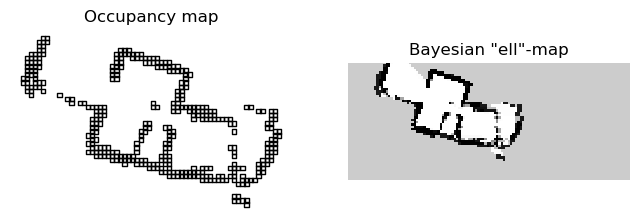

t: 12... occ: 362...  0.085103 seconds (620.00 k allocations: 76.437 MiB, 20.08% gc time)


PyObject <matplotlib.image.AxesImage object at 0x7f9cb0310f90>

In [230]:
# Initial trace
ell_map = Map(map_args...)
p0 = Pose([0;0], mod(poses[1].hd,2π))
inverse_polar_lidar!(ell_map, p0, senses[1], z_eps, free, prior, occ)
args = (0, p0, m, control_args, motion_args, sensor_args)
tr, w = generate(loc_chain, args, choicemap())

history = []

for t=1:T
    m = thresh(ell_map, occ_thresh)
    
    new_obs = choicemap()
    set_u!(new_obs, us[t], t)
    set_z!(new_obs, senses[t+1].z, t)
    
    print("t: $(t)... occ: $(length(occupied(m)))...")
    @time begin
        global tr
        args = (t, p0, m, control_args, motion_args, sensor_args)
        diffs = changes([1,0,1,0,0,0,0])
        tr, _,_,_  = update(tr, args, diffs, new_obs)

        for i=1:100
            
           tr, = mh(tr, select(t => :pose)) 
        end
    end


    p = tr[t => :pose]    
    s = tr[t => :sense]
    inverse_polar_lidar!(ell_map, p, s, z_eps, free, prior, occ)
    
    push!(history, (tr, m))
end



# -----------------
# -----------------
fig, axs = plt.subplots(1,2,figsize=(8,4)); 
axs[1].set_aspect(1.); axs[1].axis("off")
axs[2].set_aspect(1.); axs[2].axis("off")
axs[1].set_title("Occupancy map")
axs[2].set_title("Bayesian \"ell\"-map")
draw_sq_map!(m, ax=axs[1], s=10);
draw_map_im!(expit(ell_map), vmin=0, vmax=1, ax=axs[2])

In [236]:
function draw_tr_M!(tr, M; ax=plt.gca())
    t, = get_args(tr)
    draw_sq_map!(M; ax=ax, s=10)
    draw_pose!(tr[t => :pose], ax=ax)
    draw_sense!(tr[t => :sense],tr[t => :pose], ax=ax)
end

function CartesianIndex(t::Int, size::Tuple{Int64,Int64}, col=true)
    n = col ? size[1] : size[2]
    i = mod(t-1,n) + 1 
    j = div(t - 1, n) + 1
    return col ? CartesianIndex(i, j) : CartesianIndex(j, i)
end

CartesianIndex

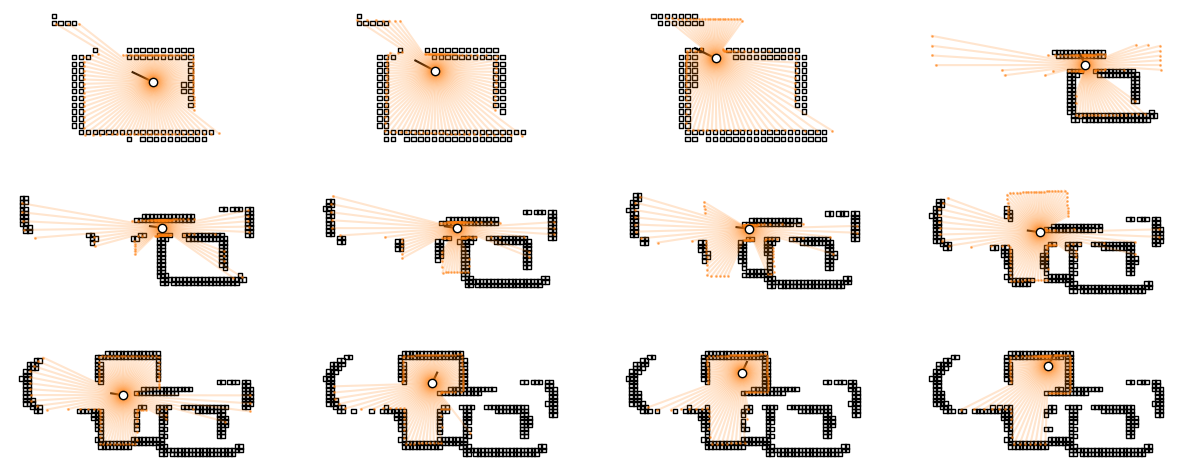

In [240]:
rows = Int(ceil(length(history)/4))
fig, axs = plt.subplots(Int(ceil(length(history)/4)), 4, figsize=(15,2*rows))
for ax in axs ax.axis("off");ax.set_aspect(1); end
for (t,(tr,M)) in enumerate(history)
    ax = axs[CartesianIndex(t,size(axs),false)]
    draw_tr_M!(tr, M, ax=ax)
end